In [1]:
import os
import sys
import argparse
import json
import numpy as np
import re
import random
import logging
import _pickle as cPickle
from utils import tokenize

curr_path = os.path.abspath('./')
api_path = os.path.join(curr_path, 'coco/PythonAPI')
sys.path.append(api_path)
print(sys.path)
from pycocotools.coco import COCO

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

['', '/anaconda3/lib/python36.zip', '/anaconda3/lib/python3.6', '/anaconda3/lib/python3.6/lib-dynload', '/anaconda3/lib/python3.6/site-packages', '/anaconda3/lib/python3.6/site-packages/aeosa', '/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/Users/junjiedong/.ipython', '/Users/junjiedong/Desktop/CS231N/Project/CS231N_Project/coco/PythonAPI']


In [2]:
params={'max_length': 30, 'word_count_threshold':5, 'num_val': 5000, 'num_test': 5000}

<class 'list'>
123287
{'file_path': 'val/COCO_val2014_000000391895.jpg', 'id': 391895, 'captions': ['A man with a red helmet on a small moped on a dirt road. ', 'Man riding a motor bike on a dirt road on the countryside.', 'A man riding on the back of a motorcycle.', 'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ', 'A man in a red shirt and a red hat is on a motorcycle on a hill side.']}
(360, 640, 3)


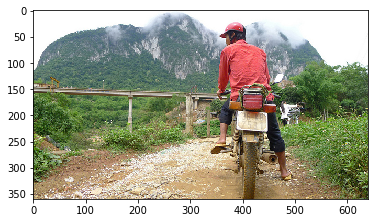

In [3]:
# Check the densed summary file
raw = json.load(open('data/coco_raw.json', 'r'))
print(type(raw))
print(len(raw))

first_img = raw[0]
print(first_img)
image = mpimg.imread('coco/images/' + first_img['file_path'])
print(image.shape)
plt.imshow(image)

In [4]:
# Some helper functions to examine the correctness of preprocessing
def check_exlusive_sets(set1, set2):
    for key in set1:
        if key in set2:
            print("Something wrong.")
    for key in set2:
        if key in set1:
            print("Something wrong.")
            
def show_image(img_id):
    for im in raw:
        if im['id'] == img_id:
            image = mpimg.imread('coco/images/' + im['file_path'])
            plt.figure()
            plt.imshow(image)
            
def check_caption_map(caption_map):
    for k in list(caption_map.keys())[:5]:
        image_id = caption_id_2_img_id[k]
        print(k, caption_map[k])
        show_image(image_id)
        
def show_dict(d, num):
    # Show "num" key-val pairs of dictionary "d"
    for k, v in list(d.items())[:num]:
        print(k, v)
    print()

In [5]:
# Load in all the saved variables
caption_id_2_img_id = cPickle.load(open("data/caption_id_2_img_id.p", 'rb'))

train_caption_id_2_caption = cPickle.load(open("data/train_caption_id_2_caption.p", 'rb'))
val_caption_id_2_caption = cPickle.load(open("data/val_caption_id_2_caption.p", 'rb'))
test_caption_id_2_caption = cPickle.load(open("data/test_caption_id_2_caption.p", 'rb'))

length_2_caption_id = cPickle.load(open("data/length_2_caption_id.p", 'rb'))
length_2_num_captions = cPickle.load(open("data/length_2_num_captions.p", 'rb'))

In [6]:
# Images belong to the train/val/test sets
# This is also a sanity check for "caption_id_2_img_id"
train_imgids = set([caption_id_2_img_id[k] for k in train_caption_id_2_caption.keys()])
val_imgids = set([caption_id_2_img_id[k] for k in val_caption_id_2_caption.keys()])
test_imgids = set([caption_id_2_img_id[k] for k in test_caption_id_2_caption.keys()])
print("Training set # of images: ", len(train_imgids))
print("Val set # of images: ", len(val_imgids))
print("Test set # of images: ", len(test_imgids))
assert len(val_imgids) == params['num_val']
assert len(test_imgids) == params['num_test']

Training set # of images:  113287
Val set # of images:  5000
Test set # of images:  5000


In [7]:
# Check the sizes of the train/val/test sets
print("Total # of captions: ", len(caption_id_2_img_id))
print("Training set # of captions: ", len(train_caption_id_2_caption.keys()))
print("Val set # of captions: ", len(val_caption_id_2_caption.keys()))
print("Test set # of captions: ", len(test_caption_id_2_caption.keys()))

Total # of captions:  616767
Training set # of captions:  566735
Val set # of captions:  25022
Test set # of captions:  25010


In [8]:
# Check the basic format of the id_2_caption maps
show_dict(train_caption_id_2_caption, 10)
show_dict(val_caption_id_2_caption, 10)
show_dict(test_caption_id_2_caption, 10)

257700 <SOS> a couple of people on snowboards moving across a track <EOS>
150550 <SOS> a horse peeking out from underneath an archway . <EOS>
441099 <SOS> four people on a sailboat one is on the phone and three are sunbathing . <EOS>
640473 <SOS> a group of people sitting at a table eating food . <EOS>
622986 <SOS> an old dodgers baseball game with a player sliding into home plate . <EOS>
553520 <SOS> bananas are on top of a dessert with sugar . <EOS>
447506 <SOS> a room filled with wooden floors and furniture . <EOS>
337618 <SOS> a car decorated like a float with a large umbrella in place of a roof . <EOS>
156265 <SOS> there is a metal toilet in a round stall <EOS>
655065 <SOS> a man is carrying a large instrument in a black case . <EOS>

462722 <SOS> a clock tower with a bird sculpture on top <EOS>
761696 <SOS> a woman is standing in the kitchen with another woman . <EOS>
809295 <SOS> an old fashioned kitchen with a multiple compartment oven . <EOS>
184339 <SOS> baby elephant with ea

In [9]:
# Make sure no caption belongs to more than one set
train_caption_ids = set(train_caption_id_2_caption)
val_caption_ids = set(val_caption_id_2_caption)
test_caption_ids = set(test_caption_id_2_caption)

check_exlusive_sets(train_caption_ids, val_caption_ids)
check_exlusive_sets(train_caption_ids, test_caption_ids)
check_exlusive_sets(val_caption_ids, test_caption_ids)

257700 <SOS> a couple of people on snowboards moving across a track <EOS>
150550 <SOS> a horse peeking out from underneath an archway . <EOS>
441099 <SOS> four people on a sailboat one is on the phone and three are sunbathing . <EOS>
640473 <SOS> a group of people sitting at a table eating food . <EOS>
622986 <SOS> an old dodgers baseball game with a player sliding into home plate . <EOS>


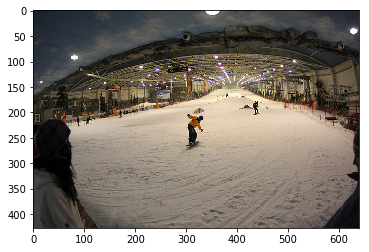

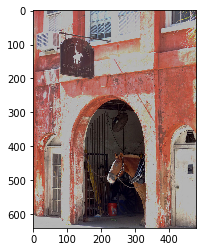

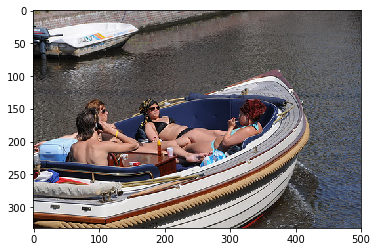

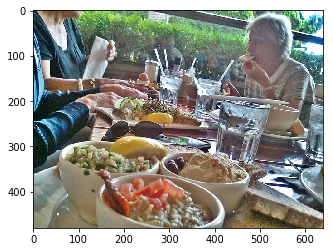

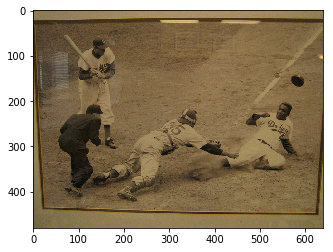

In [10]:
# See some examples from the train set
check_caption_map(train_caption_id_2_caption)

462722 <SOS> a clock tower with a bird sculpture on top <EOS>
761696 <SOS> a woman is standing in the kitchen with another woman . <EOS>
809295 <SOS> an old fashioned kitchen with a multiple compartment oven . <EOS>
184339 <SOS> baby elephant with ears spread standing in front of larger elephant . <EOS>
291103 <SOS> a man in sunglasses doing tricks on his skateboard . <EOS>


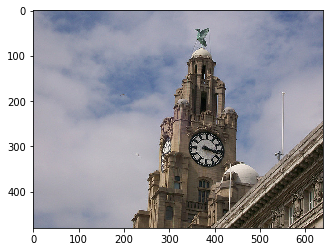

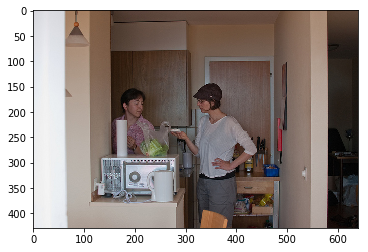

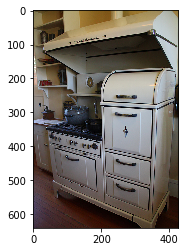

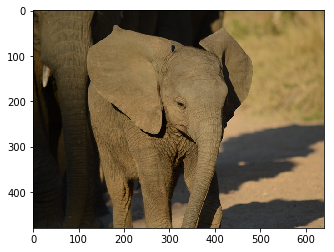

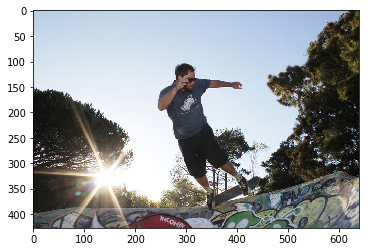

In [11]:
# See some examples from the val set
check_caption_map(val_caption_id_2_caption)

496237 <SOS> a man standing on a tennis court holding a racquet . <EOS>
282895 <SOS> the tail end of an airplane and some baggage carts on an airstrip . <EOS>
772891 <SOS> some people who are standing near some passenger buses . <EOS>
154347 <SOS> a wooden table topped with a white plate with a pizza . <EOS>
426382 <SOS> a black bird is sitting on a parking meter and some cars <EOS>


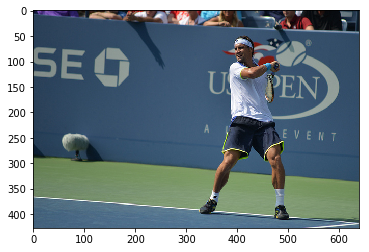

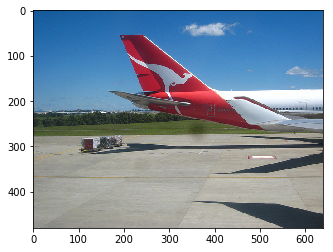

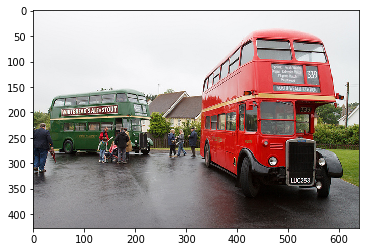

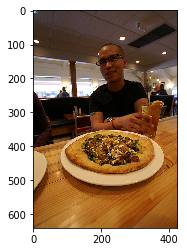

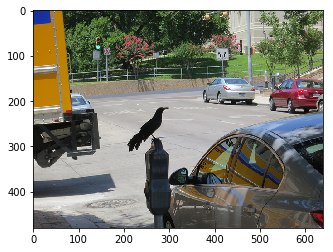

In [12]:
# See some examples from the test set
check_caption_map(test_caption_id_2_caption)

In [13]:
# Check length_2_caption_id
print(length_2_caption_id[8])
print(sum(length_2_num_captions.values()))

train_caption_id_2_caption[length_2_caption_id[8][0]]

[787217, 27468, 799606]
566735


'<SOS> some zebras dirt plants and bushes <EOS>'